## Inversion Net Supervised Learning Setting

In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt

import os
import sys

import warnings
warnings.filterwarnings('ignore')

import tqdm
from model import *

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable
from torch.optim.lr_scheduler import ExponentialLR

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import scipy.ndimage

from tqdm.notebook import tqdm
from tqdm import tqdm

from torchmetrics.functional import mean_absolute_error, mean_absolute_percentage_error, mean_squared_log_error


GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
#     torch.cuda.set_device(0)
    device = torch.device("cuda:2")  
    torch.cuda.empty_cache()
    print("Total number of GPU available -",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

Total number of GPU available - 8


In [3]:
import gc

gc.collect()

torch.cuda.empty_cache()

## Loading Amplitude and Velocity Data for Flat Layers

In [4]:
#FlatVel examples
data1 = np.load('FlatVel-A/amplitude/data1.npy')
data2 = np.load('FlatVel-A/amplitude/data2.npy')
data3 = np.load('FlatVel-A/amplitude/data3.npy')
data4 = np.load('FlatVel-A/amplitude/data4.npy')


model1 = np.load('FlatVel-A/velocity/model1.npy')
model2 = np.load('FlatVel-A/velocity/model2.npy')
model3 = np.load('FlatVel-A/velocity/model3.npy')
model4 = np.load('FlatVel-A/velocity/model4.npy')
# print(len(model1[0:2]))
# print(data1[:100].shape)


# converting to torch tensor
data1 = torch.tensor(data1).type(dtype).to(device)
data2 = torch.tensor(data2).type(dtype).to(device)
data3 = torch.tensor(data3).type(dtype).to(device)
data4 = torch.tensor(data4).type(dtype).to(device)


model1 = torch.tensor(model1).type(dtype).to(device)
model2 = torch.tensor(model2).type(dtype).to(device)
model3 = torch.tensor(model3).type(dtype).to(device)
model4 = torch.tensor(model4).type(dtype).to(device)

## Custom Data Loader class to load data using PyTorch Dataloader

In [5]:
class DatasetLoader(Dataset):
    
    def __init__(self, amps, vel):
        self.amps = amps
        self.vel = vel
    
    
    def __getitem__(self, idx):
        
        return (self.amps[idx], self.vel[idx])
    
    def __len__(self):
        
        return len(self.amps)


In [6]:
print(model1.shape)

torch.Size([500, 1, 70, 70])


In [7]:
total_data = torch.cat((data1, data2, data3, data4), 0)
total_model = torch.cat((model1, model2, model3, model4), 0)

data = DatasetLoader(total_data, total_model)

In [8]:
print(len(data)*0.8)

1600.0


In [9]:
train_size = int(len(data)*0.8)
test_size = len(data) - train_size

train_data, test_data = torch.utils.data.random_split(data, [train_size, test_size])

trainloader = DataLoader(train_data, batch_size=50, shuffle=True)
testloader = DataLoader(test_data, batch_size=50, shuffle=True)

## Defining InversionNet model

In [10]:
input_channels = 5
encoder_channels = [32, 64, 64, 64, 64, 128, 128, 128, 128,
                   256, 256, 256, 256, 512]

decoder_channels = [512, 256, 128, 64, 32]

net = InversionNetB(input_channels, encoder_channels, decoder_channels).type(dtype).to(device)

# net = nn.DataParallel(InversionNetB(input_channels, encoder_channels, decoder_channels)).type(dtype).to(device)

#net = InversionNet().type(dtype).to(device)

In [11]:
## Optimization Params
params = [p for p in net.parameters()]

l2_loss = torch.nn.MSELoss()
l1_loss = torch.nn.L1Loss()

c1 = 0.3

# optimizer = torch.optim.Adam([{'params':params, 'lr':1e-6}])
optimizer = torch.optim.SGD(params, lr=1e-4)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.2)

  0%|                                                  | 0/2000 [00:00<?, ?it/s]

Model Loss at 0 epoch - 5793403.8125


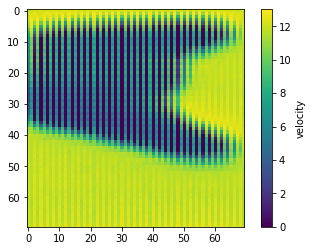

 10%|███▊                                  | 200/2000 [13:15<1:59:54,  4.00s/it]

Model Loss at 200 epoch - 975673.240234375


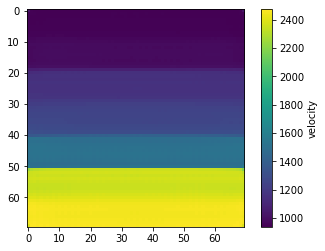

 20%|███████▌                              | 400/2000 [26:34<1:46:39,  4.00s/it]

Model Loss at 400 epoch - 166796.49096679688


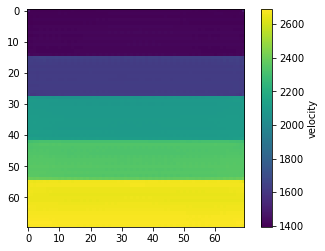

 30%|███████████▍                          | 600/2000 [39:54<1:33:11,  3.99s/it]

Model Loss at 600 epoch - 30838.506225585938


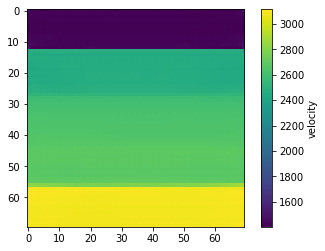

 40%|███████████████▏                      | 800/2000 [53:14<1:19:58,  4.00s/it]

Model Loss at 800 epoch - 8219.897899627686


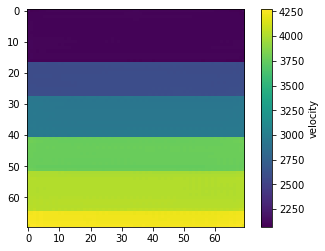

 50%|█████████████████▌                 | 1000/2000 [1:06:33<1:06:34,  3.99s/it]

Model Loss at 1000 epoch - 4088.8277077674866


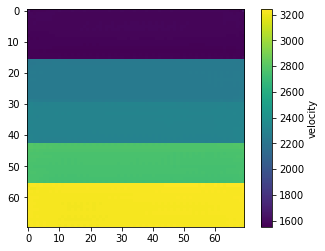

 60%|██████████████████████▏              | 1200/2000 [1:19:53<53:17,  4.00s/it]

Model Loss at 1200 epoch - 2664.570948600769


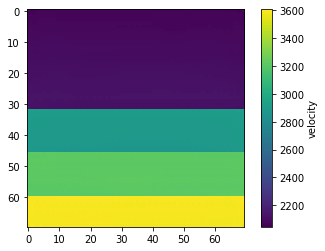

 70%|█████████████████████████▉           | 1400/2000 [1:33:13<40:03,  4.01s/it]

Model Loss at 1400 epoch - 3114.323890686035


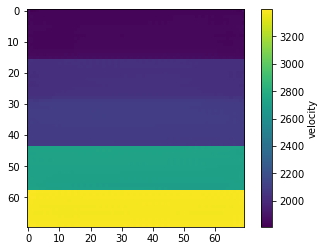

 80%|█████████████████████████████▌       | 1600/2000 [1:46:34<26:41,  4.00s/it]

Model Loss at 1600 epoch - 2919.4728260040283


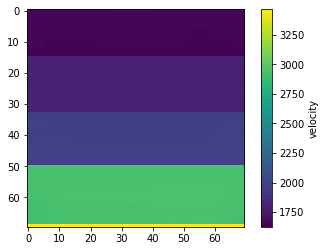

 90%|█████████████████████████████████▎   | 1800/2000 [1:59:56<13:21,  4.01s/it]

Model Loss at 1800 epoch - 3162.9283680915833


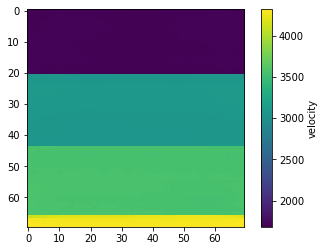

100%|█████████████████████████████████████| 2000/2000 [2:13:17<00:00,  4.00s/it]


In [10]:
# Model training
train_loss_per_epoch = []

num_epoch = 2000

for epoch in tqdm(range(num_epoch)):
    train_epoch_loss = 0
    for batch_id, (amp, vel) in enumerate(trainloader):
        optimizer.zero_grad()
        
        pred_vel = net(amp)
        
        # Loss calculation
        loss1 = l1_loss(vel, pred_vel)
        loss2 = l2_loss(vel, pred_vel)

        pixel_loss = c1*loss1 + (1-c1)*loss2
        train_epoch_loss += pixel_loss.item()
        
        
        pixel_loss.backward()
        optimizer.step()
    
#     scheduler.step()
    train_epoch_loss = train_epoch_loss/(len(trainloader)) 
        
    if(epoch%200 == 0):
        print('Model Loss at {epoch} epoch - {epoch_loss}'.format(epoch=epoch, epoch_loss=train_epoch_loss))
        
        with torch.no_grad():
            pred_vel_np = pred_vel[0,0,:].detach().cpu().numpy()
            plt.imshow(pred_vel_np)
            plt.colorbar(label='velocity')
            plt.show()
        
    train_loss_per_epoch.append(train_epoch_loss)

In [11]:
# saving model without optimizer's state_dict
# model without nn.DataParallel
torch.save(net.state_dict(), 'Checkpoints/FlatVel-A/InversionNet_FlatVel_e_2000_weights.pth')

In [12]:
#save model with optimizer's state_dict
torch.save({'epoch': num_epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss_per_epoch
           }, 'Checkpoints/FlatVel-A/InversionNet_FlatVel_optimizer_epoch_loss.pth')

In [13]:
torch.save({'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
           }, 'Checkpoints/FlatVel-A/InversionNet_FlatVel_optimizer.pth')

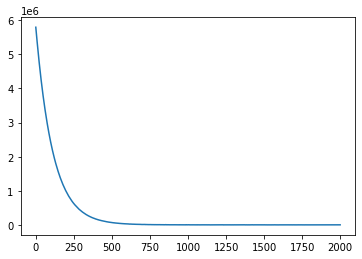

In [14]:
# loss plot
plt.plot(train_loss_per_epoch)
plt.savefig("Checkpoints/FlatVel-A/New_InversionNet_FlatVel_e_2000_pixel_loss.png")

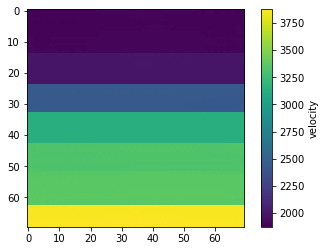

In [15]:
# comparing predicted velocity vs true velocity on train set
# predicted velocity
amp, vel = train_data[0:50]

pred_vel = net(amp)

vel = vel[15,0,:]
first_vel = pred_vel[15,0,:]

vel_np = first_vel.detach().cpu().numpy()

plt.imshow(vel_np)
plt.colorbar(label='velocity')

# saving the predicted velocity
# plt.savefig("Checkpoints/FlatVel-A/FlatVel-A_e_2000_train0_50_prediction.png")
plt.show()

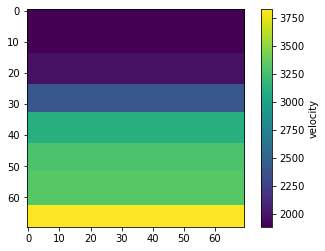

In [16]:
# true velocity
vel = vel.detach().cpu().numpy()
plt.imshow(vel)
plt.colorbar(label='velocity')

# saving the true velocity for comparision
# plt.savefig("Checkpoints/FlatVel-A/FlatVel-A_e_2000_train0_50_true.png")
plt.show()

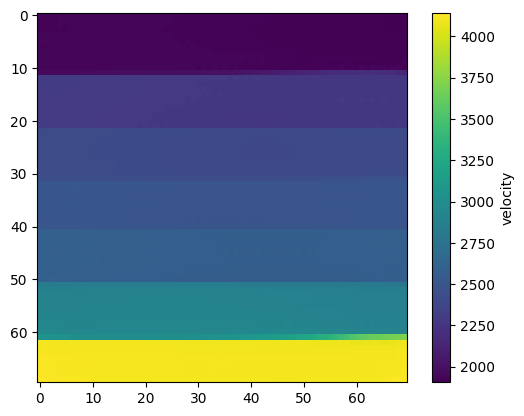

In [49]:
# comparing predicted velocity vs true velocity on test set
# predicted velocity
amp, vel = test_data[30:60]

pred_vel = net(amp)

vel = vel[10,0,:]
first_vel = pred_vel[10,0,:]

vel_np = first_vel.detach().cpu().numpy()

plt.imshow(vel_np)
plt.colorbar(label='velocity')

# plt.savefig("Checkpoints/FlatVel-A/FlatVel-A_e_2000_test30_60_prediction.png")
plt.show()

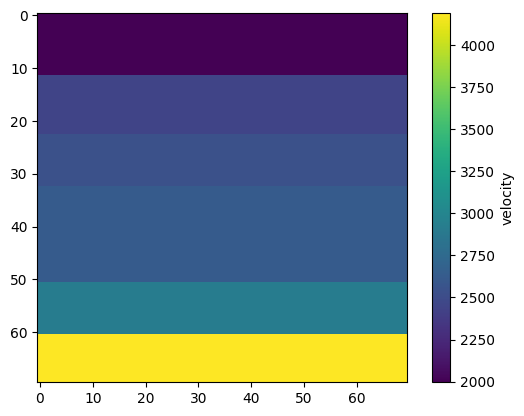

In [50]:
# true velocity
vel = vel.detach().cpu().numpy()
plt.imshow(vel)
plt.colorbar(label='velocity')

# plt.savefig("Checkpoints/FlatVel-A/FlatVel-A_e_2000_test30_60_true.png")
plt.show()

In [9]:
from pysit import *
from pysit.gallery import marmousi
from pysit.gallery import marmousi2

import deepwave


In [10]:
vp_true, vp_init, m, d = marmousi2(origin=(7500, 355), 
                        size=(1910, 950), 
                        pixel_scale="small",
                        initial_model_style="gradient",
                        initial_config={'min':1500.0,'max':3000.0})

# To load full model
# vp_true, vp_init, m, d = marmousi2(patch='mini_square',pixel_scale='mini')


plot_shape = m.shape(as_grid=True)
vp_true_np = vp_true.reshape(plot_shape).T
vp_init_np = vp_init.reshape(plot_shape).T


vp_true_var = torch.tensor(vp_true_np)
model_true = vp_true_var.clone()


In [11]:
# Model setup for DeepWave
dx = m.deltas[0]
nz, ny = vp_true_np.shape
num_dims = 2



# acquisition setup
num_shots = 20

num_sources_per_shot = 1
source_spacing = ny*dx / num_shots #10.0

num_receivers_per_shot = 96
receiver_spacing = ny*dx / num_receivers_per_shot #10.0

peak_freq = 10
dt = 0.004 # 4ms

n_seconds = 4
nt = int(n_seconds / dt)

In [12]:
#Build acquisition data

# Create arrays containing the source and receiver locations
# x_s: Source locations [num_shots, num_sources_per_shot, num_dimensions]
x_s = torch.zeros(num_shots, num_sources_per_shot, num_dims)
x_s[:, 0, 1] = torch.arange(num_shots).float() * source_spacing

# x_r: Receiver locations [num_shots, num_receivers_per_shot, num_dimensions]
x_r = torch.zeros(num_shots, num_receivers_per_shot, num_dims)
x_r[0, :, 1] = torch.arange(num_receivers_per_shot).float() * receiver_spacing
x_r[:, :, 1] = x_r[0, :, 1].repeat(num_shots, 1)

# Create true source amplitudes [nt, num_shots, num_sources_per_shot]
# We use Deepwave's Ricker wavelet function. The result is a normal Tensor - you
# can use whatever Tensor you want as the source amplitude.
source_amplitudes_true = (deepwave.wavelets.ricker(peak_freq, nt, dt, 1/peak_freq)
                          .reshape(-1, 1, 1)
                          .repeat(1, num_shots, num_sources_per_shot))

In [ ]:
prop = deepwave.scalar.Propagator({'vp': model_true.to(device)}, dx)

receiver_amplitudes_true = prop(source_amplitudes_true.to(device),
                                x_s.to(device),
                                x_r.to(device), dt).cpu()

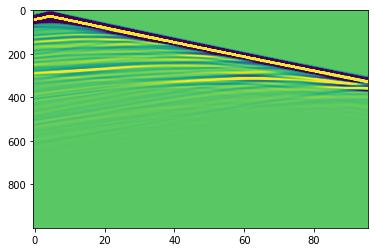

In [67]:
# Plot one shot gather
vmin, vmax = np.percentile(receiver_amplitudes_true[:,1].cpu().numpy(), [2,98])
plt.imshow(receiver_amplitudes_true[:,1].cpu().numpy(), aspect='auto',
           vmin=vmin, vmax=vmax)

In [68]:
receiver_amplitudes_true = receiver_amplitudes_true.permute(1,0,2)
receiver_amplitudes_true = receiver_amplitudes_true[None,...]
print(receiver_amplitudes_true.shape)

torch.Size([1, 20, 1000, 96])


In [70]:
receiver_amplitudes_true = receiver_amplitudes_true[:,0:5,:1000,:70]
print(receiver_amplitudes_true.shape)

torch.Size([1, 5, 1000, 70])


In [71]:
tloader_receiver_amplitudes_true = DataLoader(receiver_amplitudes_true, batch_size=50, shuffle=True)
tloader_receiver_amplitudes_true

In [74]:
print(receiver_amplitudes_true.shape)
m_pred = model(receiver_amplitudes_true.to('cpu'))



torch.Size([1, 5, 1000, 70])


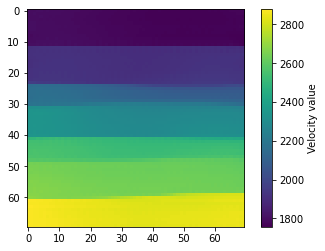

In [78]:
plt.imshow(m_pred[0,0].detach().cpu().numpy())
plt.colorbar(label="Velocity value")
plt.savefig("Checkpoints/FlatVel-A/FlatVel-A_e_2000_marmousi.png")

## Loading Model for inference

In [12]:
# Loading Model for Inference
model=InversionNetB(input_channels, encoder_channels, decoder_channels) #.type(dtype).to(device)
model.load_state_dict(torch.load('Checkpoints/FlatVel-A/Copy_1_InversionNet_FlatVel_e_2000_weights-Copy1.pth'))
model.eval()

InversionNetB(
  (conv_block_last): Sequential(
    (0): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (encoder_layers): Sequential(
    (0): Sequential(
      (0): Conv2d(5, 32, kernel_size=(7, 1), stride=(2, 1), padding=(3, 0))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 1), stride=(2, 1), padding=(1, 0))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.

Mean Absolute Error (MAE):  14.451251
Mean Relative Error (MRE):  0.005092587

Prediction


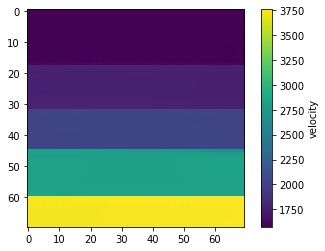

Ground Truth


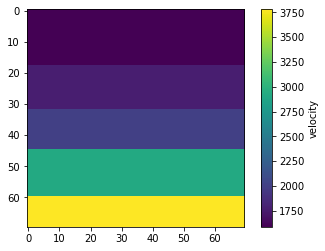

In [32]:
# Evaluation metrics - MAE and MRE
# with e=2000
amp, vel = test_data[0:]
pred_vel = model(amp.to('cpu'))

mae = mean_absolute_error(torch.tensor(pred_vel).to(device), torch.tensor(vel).to(device)).detach().cpu().numpy()
mre = mean_absolute_percentage_error(torch.tensor(pred_vel).to(device), torch.tensor(vel).to(device)).detach().cpu().numpy()
print("Mean Absolute Error (MAE): ", mae)
print("Mean Relative Error (MRE): ", mre)
print("")
vel = vel[15,0,:]
pred_vel = pred_vel[15,0,:]

print("Prediction")
pred_vel = pred_vel.detach().cpu().numpy()
plt.imshow(pred_vel)
plt.colorbar(label='velocity')
plt.show()

print("Ground Truth")
true_vel = vel.detach().cpu().numpy()
plt.imshow(true_vel)
plt.colorbar(label='velocity')
plt.show()

In [31]:
# mean_squared_log_error(torch.tensor(pred_vel).to(device), torch.tensor(vel).to(device))

In [26]:
mae=mean_absolute_error(torch.tensor(pred_vel).type(dtype).to(device), torch.tensor(vel).type(dtype).to(device))
print(mae.detach().cpu().numpy())

9.253973
